<a href="https://colab.research.google.com/github/vkt1414/Cloud-Resources-Workflows/blob/main/Notebooks/Totalsegmentator/downloadDicomAndConvertNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This Notebook does the first step in the split workflow on Terra 
DICOM files are downloaded from IDC and converted to NIFTI files with dcm2niix or plastimatch. Whenever there are multiple NIFTI files for a series, such series are prohibited from continuing to Inference. A CSV file is created with a list of such series.

Please cite:

Li X, Morgan PS, Ashburner J, Smith J, Rorden C. (2016) The first step for neuroimaging data analysis: DICOM to NIfTI conversion. J Neurosci Methods. 264:47-56.

Shackleford, James A., Nagarajan Kandasamy and Gregory C. Sharp. “Plastimatch—An Open-Source Software for Radiotherapy Imaging.” (2014).



###Installing Packages

In [ ]:
# %%capture
# #Installing dcm2niix and pigz
# !apt-get install dcm2niix pigz lz4

In [ ]:
# %%capture
# #Installing plastimatch
# !apt-get install plastimatch 

In [ ]:
# %%capture
# #install s5cmd
# !wget "https://github.com/peak/s5cmd/releases/download/v2.0.0/s5cmd_2.0.0_Linux-64bit.tar.gz"
# !tar -xvzf "s5cmd_2.0.0_Linux-64bit.tar.gz"
# !rm "s5cmd_2.0.0_Linux-64bit.tar.gz"
# !mv s5cmd /usr/local/bin/s5cmd

###Parameters for papermill

In [ ]:
converter='dcm2niix'
csvFilePath=''

###Reading CSV File containing s5cmd Urls

In [ ]:
import os
import sys
import time
import pandas as pd
from pathlib import Path
import shutil

In [ ]:
curr_dir   = Path().absolute()

print(time.asctime(time.localtime()))
print("\nCurrent directory :{}".format( curr_dir))
print("Python version    :", sys.version.split('\n')[0])

Wed Mar 22 15:13:23 2023

Current directory :/content
Python version    : 3.9.16 (main, Dec  7 2022, 01:11:51) 


In [ ]:
#get the path of the zip file containing csv file in the current working directory3
#In Terra, a zip file containing the csv file will be provided as input and will be localized
#to the current working directory.

#Since it will be the only zip file that will be provided as input, we will be unzipping 
#the first zip file in the current working directory.

import glob

#zip_file_path = glob.glob('*.zip')[0]
#zip_file_path='/content/drive/MyDrive/result.zip'
#!unzip $zip_file_path

#csv_file_path = glob.glob('*.csv')[0]
#csv_file_path= '/home/vamsi/Downloads/result.csv'
csv_file_path=csv_file_path.replace("gs://", "/cromwell_root/")

start_time = time.time()
cohort_df=pd.read_csv(csv_file_path, delimiter=',', encoding='utf-8')
#cohort_df= pd.read_csv('/content/drive/MyDrive/bquxjob_7f0d87d5_187056e0dd3.csv') #two nifti files example
#cohort_df= pd.read_csv('/content/drive/MyDrive/bq-results-20230315-160529-1678896367937/bq-results-20230315-160529-1678896367937.csv')
read_time=time.time() -start_time
print('read in '+str(read_time)+ '  seconds')

read in 0.14537572860717773  seconds


In [ ]:
SeriesInstanceUIDs= cohort_df["SeriesInstanceUID"].sample(n=10).values.tolist()
# SeriesInstanceUIDs=[
# # '1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533',
# # '1.3.6.1.4.1.14519.5.2.1.7009.9004.100148350742920339334061834697',
# #series that create two volumes
# '1.3.6.1.4.1.14519.5.2.1.7009.9004.946109466334058509440732472138',
# '1.2.840.113654.2.55.99651797089556982668213819691341139949'  
# ]

###Defining Functions

In [ ]:
#Creating Directories
if converterType.lower()=='dcm2niix':
  try:
    shutil.rmtree('dcm2niix')
  except OSError:
    pass
  os.mkdir('dcm2niix')
else:
  try:
    shutil.rmtree('plastimatch')
  except OSError:
    pass
  os.mkdir('plastimatch')

In [ ]:
def download_dicom_data(series_id):

  """
  Download raw DICOM data into "idc_data" folder.
  """
  global cohort_df
  gs_file_path = "s5cmd_manifest.txt"
  #when bigquery is used the following line could be used
  #cohort_df = bq_client.query(selection_query).to_dataframe()
  series_df=cohort_df[cohort_df['SeriesInstanceUID']==series_id]
  series_df["s5cmdUrls"].to_csv(gs_file_path, header = False, index = False)
  #remove double quotes from the manifest file
  !sed -i 's/"//g' s5cmd_manifest.txt  

  start_time = time.time()
  print("Copying files from IDC buckets..")

  #!cat $gs_file_path | gsutil -q -m cp -Ir $download_path >> /dev/null
  !s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run s5cmd_manifest.txt  >> /dev/null

  elapsed = time.time() - start_time
  print("Done in %g seconds."%elapsed)

In [ ]:
def convert_dicom_to_nifti(series_id):
  if converterType.lower()=='dcm2niix':
    try:
      shutil.rmtree(f'dcm2niix/{series_id}')
    except OSError:
      pass
    os.mkdir(f'dcm2niix/{series_id}')

    !dcm2niix -z y -f %j_%p_%t_%s -b n -m y -o  /{curr_dir}/dcm2niix/{series_id}  /{curr_dir}/idc_data/
  else:
    try:
      shutil.rmtree(f'plastimatch/{series_id}')
    except OSError:
      pass
    os.mkdir(f'plastimatch/{series_id}')
    """
    Make sure to check the s5cmd urls for the destination directory and 
    plastimatch input directory must be changed accordingly
    dcm2niix, however, checks upto depth 5 to find DICOM files

    """
    !plastimatch convert --input /{curr_dir}/idc_data/{series_id} --output-img /{curr_dir}/plastimatch/{series_id}/{series_id}.nii.gz


  try:
      shutil.rmtree('idc_data')
  except OSError:
      pass
  os.mkdir('idc_data')

In [ ]:
import os
import zipfile
from concurrent.futures import ThreadPoolExecutor
from time import sleep
from datetime import datetime
import psutil
import pandas as pd
import matplotlib.pyplot as plt

class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True

    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb

In [ ]:
def download_and_process_series(series_id):
    log = pd.DataFrame({'SeriesInstanceUID': [series_id]})

    start_time = time.time()
    download_dicom_data( series_id)
    download_time = time.time() - start_time

    log['download_time'] = download_time

    start_time = time.time()
    convert_dicom_to_nifti(series_id)
    convert_dicom_to_nifti_time = time.time() - start_time

    log['NiftiConverter_time'] = convert_dicom_to_nifti_time

    global runtime_stats
    runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)



###Downloading and Converting

Copying files from IDC buckets..
Done in 1.51953 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 491 DICOM file(s)
Convert 491 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.733117372429656659742127849071/1.3.6.1.4.1.14519.5.2.1.7009.9004.73311737242965665974212784907_1_OPA_GE_LS16_STANDARD_320_0.6_120_144_104.7_1.4_20000102000000_2 (512x512x491x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.733117372429656659742127849071/1.3.6.1.4.1.14519.5.2.1.7009.9004.73311737242965665974212784907_1_OPA_GE_LS16_STANDARD_320_0.6_120_144_104.7_1.4_20000102000000_2.nii"
Conversion required 20.920686 seconds (0.843774 for core code).


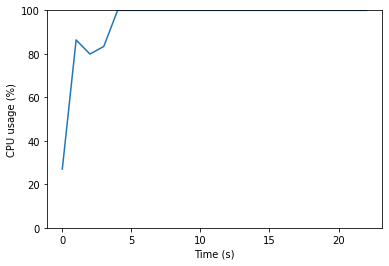

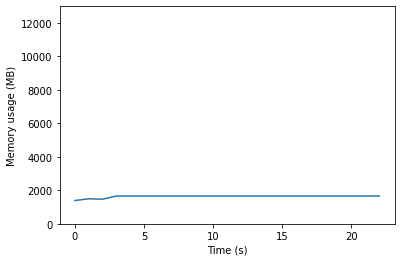

Copying files from IDC buckets..
Done in 1.42614 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 440 DICOM file(s)
Convert 440 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.170901486168382528079104337556/1.3.6.1.4.1.14519.5.2.1.7009.9004.17090148616838252807910433755_2_OPA_GE_LS16_STANDARD_360_1.2_120_70_50.9_1.4_20010102000000_2 (512x512x440x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.170901486168382528079104337556/1.3.6.1.4.1.14519.5.2.1.7009.9004.17090148616838252807910433755_2_OPA_GE_LS16_STANDARD_360_1.2_120_70_50.9_1.4_20010102000000_2.nii"
Conversion required 17.015388 seconds (0.727577 for core code).


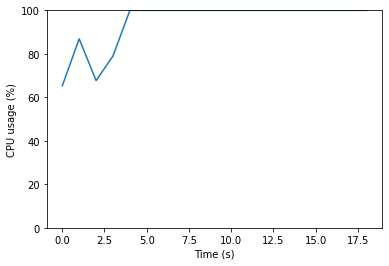

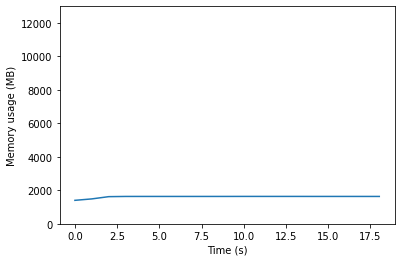

Copying files from IDC buckets..
Done in 1.32031 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 350 DICOM file(s)
Convert 350 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.173170853908044997397123665862/1.3.6.1.4.1.14519.5.2.1.7009.9004.17317085390804499739712366586_2_OPA_GE_LS16_STANDARD_280_1.2_120_70_50.9_1.4_20010102000000_2 (512x512x350x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.173170853908044997397123665862/1.3.6.1.4.1.14519.5.2.1.7009.9004.17317085390804499739712366586_2_OPA_GE_LS16_STANDARD_280_1.2_120_70_50.9_1.4_20010102000000_2.nii"
Conversion required 13.599368 seconds (0.619141 for core code).


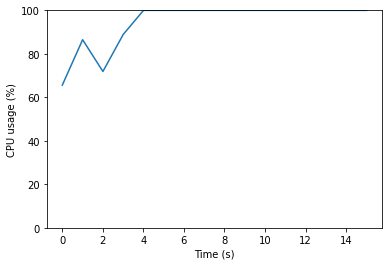

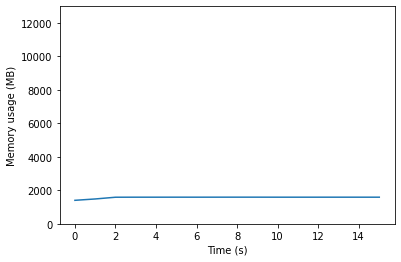

Copying files from IDC buckets..
Done in 1.532 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 457 DICOM file(s)
Convert 457 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.329454839643246158711092793890/1.3.6.1.4.1.14519.5.2.1.7009.9004.32945483964324615871109279389_2_OSA_GE_LS16_STANDARD_320_1.2_120_70_50.9_1.4_20010102000000_102 (512x512x457x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.329454839643246158711092793890/1.3.6.1.4.1.14519.5.2.1.7009.9004.32945483964324615871109279389_2_OSA_GE_LS16_STANDARD_320_1.2_120_70_50.9_1.4_20010102000000_102.nii"
Conversion required 18.897186 seconds (0.784559 for core code).


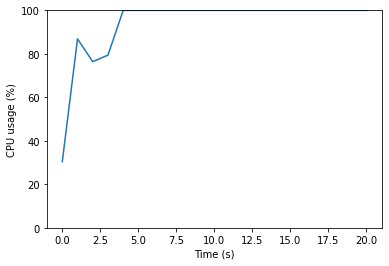

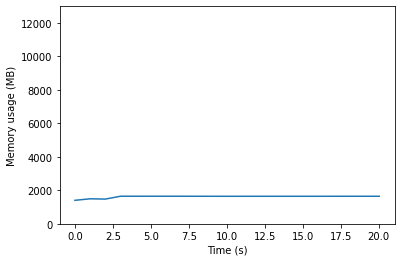

Copying files from IDC buckets..
Done in 1.53536 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 451 DICOM file(s)
Convert 451 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.146169319628002365923929765651/1.3.6.1.4.1.14519.5.2.1.7009.9004.14616931962800236592392976565_2_OPA_GE_LS16_STANDARD_315_1.2_120_70_50.9_1.4_20010102000000_2 (512x512x451x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.146169319628002365923929765651/1.3.6.1.4.1.14519.5.2.1.7009.9004.14616931962800236592392976565_2_OPA_GE_LS16_STANDARD_315_1.2_120_70_50.9_1.4_20010102000000_2.nii"
Conversion required 17.411982 seconds (0.766249 for core code).


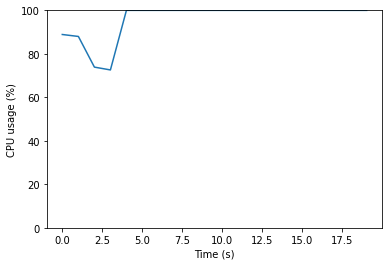

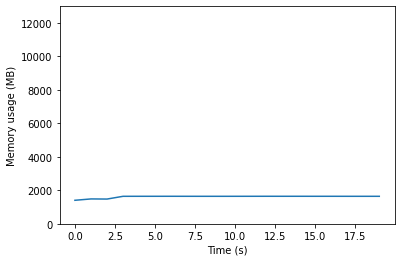

Copying files from IDC buckets..
Done in 1.7233 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 453 DICOM file(s)
Convert 453 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.281442150085452545908657153882/1.3.6.1.4.1.14519.5.2.1.7009.9004.28144215008545254590865715388_2_OPA_GE_LS16_STANDARD_300_1.2_120_70_50.9_1.4_20010102000000_2 (512x512x453x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.281442150085452545908657153882/1.3.6.1.4.1.14519.5.2.1.7009.9004.28144215008545254590865715388_2_OPA_GE_LS16_STANDARD_300_1.2_120_70_50.9_1.4_20010102000000_2.nii"
Conversion required 17.828496 seconds (0.861348 for core code).


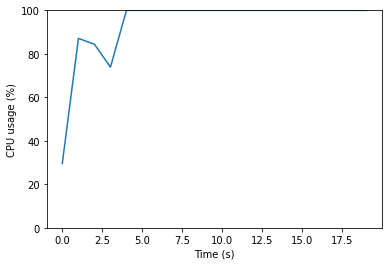

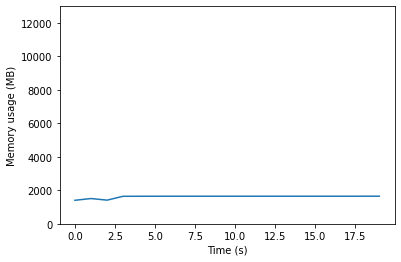

Copying files from IDC buckets..
Done in 2.35869 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 444 DICOM file(s)
Convert 444 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.232085097739286069987727730632/1.3.6.1.4.1.14519.5.2.1.7009.9004.23208509773928606998772773063_2_OPA_GE_LS16_STANDARD_400_1.2_120_70_50.9_1.4_20010102000000_2 (512x512x444x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.232085097739286069987727730632/1.3.6.1.4.1.14519.5.2.1.7009.9004.23208509773928606998772773063_2_OPA_GE_LS16_STANDARD_400_1.2_120_70_50.9_1.4_20010102000000_2.nii"
Conversion required 17.751184 seconds (0.875054 for core code).


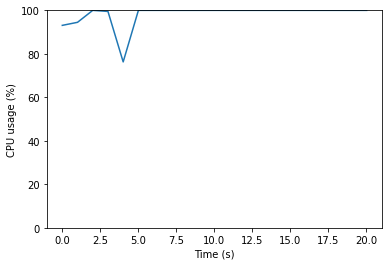

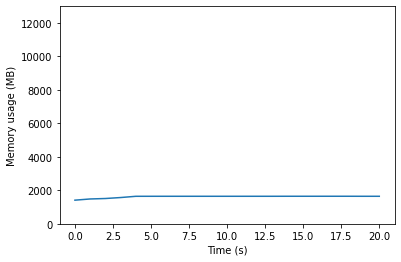

Copying files from IDC buckets..
Done in 1.54954 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 471 DICOM file(s)
Convert 471 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.315472835069304488500404379375/1.3.6.1.4.1.14519.5.2.1.7009.9004.31547283506930448850040437937_2_OPA_GE_LSPR16_STANDARD_330_1.2_120_80_58.2_1.4_20010102000000_3 (512x512x471x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.315472835069304488500404379375/1.3.6.1.4.1.14519.5.2.1.7009.9004.31547283506930448850040437937_2_OPA_GE_LSPR16_STANDARD_330_1.2_120_80_58.2_1.4_20010102000000_3.nii"
Conversion required 14.751991 seconds (0.815794 for core code).


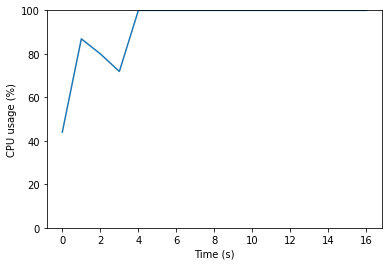

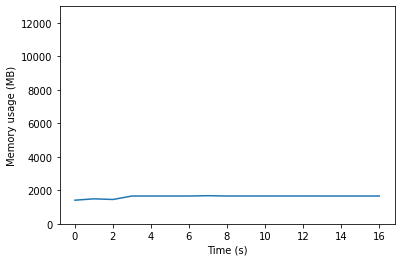

Copying files from IDC buckets..
Done in 1.62578 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 461 DICOM file(s)
Convert 461 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.162274427304615677708118002304/1.3.6.1.4.1.14519.5.2.1.7009.9004.16227442730461567770811800230_1_OPA_GE_LSPR16_STANDARD_360_1.2_120_80_58.2_1.4_20000102000000_3 (512x512x461x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.162274427304615677708118002304/1.3.6.1.4.1.14519.5.2.1.7009.9004.16227442730461567770811800230_1_OPA_GE_LSPR16_STANDARD_360_1.2_120_80_58.2_1.4_20000102000000_3.nii"
Conversion required 15.654987 seconds (0.788316 for core code).


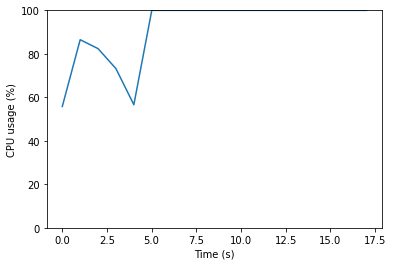

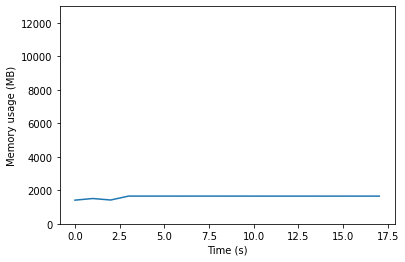

Copying files from IDC buckets..
Done in 1.63197 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 418 DICOM file(s)
Convert 418 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/1.3.6.1.4.1.14519.5.2.1.7009.9004.21767310514022109288482935440_2_OPA_GE_LS16_STANDARD_290_1.2_120_70_50.9_1.4_20010102000000_2 (512x512x418x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/1.3.6.1.4.1.14519.5.2.1.7009.9004.21767310514022109288482935440_2_OPA_GE_LS16_STANDARD_290_1.2_120_70_50.9_1.4_20010102000000_2.nii"
Conversion required 17.672448 seconds (0.865868 for core code).


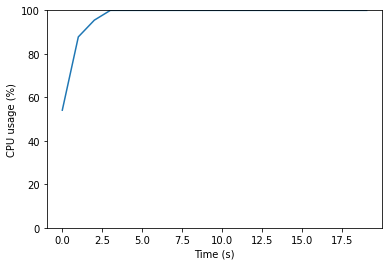

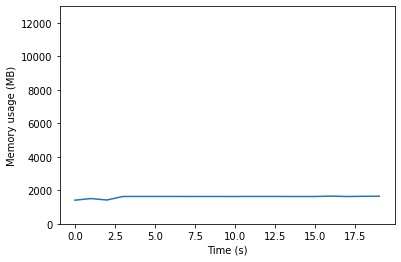

In [ ]:
runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','download_time',
                                      'NiftiConverter_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb'
                                      ])
if __name__ == "__main__":
    for series_id in SeriesInstanceUIDs:
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(download_and_process_series, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb = mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]
                

                plt.plot(time_stamps, cpu_usage)
                plt.ylim(0, 100)
                plt.xlabel('Time (s)')
                plt.ylabel('CPU usage (%)')
                plt.show()

                plt.plot(time_stamps, ram_usage_mb)
                plt.ylim(0, ram_total_mb)
                plt.xlabel('Time (s)')
                plt.ylabel('Memory usage (MB)')
                plt.show()


###Monitoring for dcm2niix Errors

In [ ]:
import os
import csv

# def check_dcm2niix_errors(path):
#     with open('dcm2niix_errors.csv', 'w') as csvfile:
#         writer = csv.writer(csvfile)
#         for series_id in os.listdir(path):
#             series_id_path = os.path.join(path, series_id)
#             if os.path.isdir(series_id_path):
#                 num_files = len([f for f in os.listdir(series_id_path) if os.path.isfile(os.path.join(series_id_path, f))])
#                 if num_files > 1:
#                     print(f'Found one more than one nifti for the {series_id}')
#                     writer.writerow([series_id])
#                     shutil.rmtree(f'dcm2niix/{series_id}')


def check_dcm2niix_errors(path):
    for series_id in os.listdir(path):
        series_id_path = os.path.join(path, series_id)
        if os.path.isdir(series_id_path):
            num_files = len([f for f in os.listdir(series_id_path) if os.path.isfile(os.path.join(series_id_path, f))])
            if num_files > 1:
                print(f'Found one more than one nifti for the {series_id}')
                with open('dcm2niix_errors.csv', 'a') as csvfile:
                    writer = csv.writer(csvfile)
                    writer.writerow([series_id])
                shutil.rmtree(f'dcm2niix/{series_id}')


In [ ]:
if converterType.lower()=='dcm2niix':
    check_dcm2niix_errors(f'/{curr_dir}/dcm2niix')

###Zipping Output Files


In [ ]:
if converterType.lower()=='dcm2niix':
  start_time = time.time()
  #!zip -j -r -m downloadDicomAndConvertNiftiFiles.zip {curr_dir}/dcm2niix
  try:
    os.remove('downloadDicomAndConvertNiftiFiles.tar.lz4')
  except OSError:
    pass
  !tar cvf - {curr_dir}/dcm2niix | lz4 > downloadDicomAndConvertNiftiFiles.tar.lz4
  archiving_time = time.time() - start_time
else:
  start_time = time.time()
  try:
    os.remove('downloadDicomAndConvertNiftiFiles.tar.lz4')
  except OSError:
    pass
  !tar cvf - {curr_dir}/plastimatch | lz4 > downloadDicomAndConvertNiftiFiles.tar.lz4
  #!zip -j -r -m downloadDicomAndConvertNiftiFiles.zip {curr_dir}/plastimatch
  archiving_time = time.time() - start_time

tar: Removing leading `/' from member names
/content/dcm2niix/
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/1.3.6.1.4.1.14519.5.2.1.7009.9004.21767310514022109288482935440_2_OPA_GE_LS16_STANDARD_290_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.146169319628002365923929765651/
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.146169319628002365923929765651/1.3.6.1.4.1.14519.5.2.1.7009.9004.14616931962800236592392976565_2_OPA_GE_LS16_STANDARD_315_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.232085097739286069987727730632/
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.232085097739286069987727730632/1.3.6.1.4.1.14519.5.2.1.7009.9004.23208509773928606998772773063_2_OPA_GE_LS16_STANDARD_400_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz
/content/dcm2niix/1.3.6.1.4.1.1

###Utilization Metrics

In [ ]:
runtime_stats.to_csv('runtime.csv')
runtime_stats['csv_read_time']=read_time
runtime_stats['archiving_time']=archiving_time

#!zip -j -r downloadDicomAndConvertUsageMetrics.zip  {curr_dir}/runtime.csv
try:
  os.remove('downloadDicomAndConvertUsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv downloadDicomAndConvertUsageMetrics.lz4
runtime_stats

Compressed 5464 bytes into 2510 bytes ==> 45.94%


,SeriesInstanceUID,download_time,NiftiConverter_time,cpu_usage,ram_usage_mb,ram_total_mb,csv_read_time,archiving_time
0,1.3.6.1.4.1.14519.5.2.1.7009.9004.733117372429...,1.637134,21.068480,"[[[27.0, 86.4, 79.9, 83.4, 100.0, 100.0, 100.0...","[[[1388.69921875, 1494.07421875, 1468.72265625...",[12985.546875],0.145376,4.050716
1,1.3.6.1.4.1.14519.5.2.1.7009.9004.170901486168...,1.548409,17.149352,"[[[65.3, 86.9, 67.7, 79.0, 100.0, 100.0, 100.0...","[[[1401.4921875, 1486.921875, 1621.171875, 163...",[12985.546875],0.145376,4.050716
2,1.3.6.1.4.1.14519.5.2.1.7009.9004.173170853908...,1.439587,13.746369,"[[[65.6, 86.5, 71.9, 88.9, 100.0, 100.0, 100.0...","[[[1402.3515625, 1483.5625, 1586.87890625, 158...",[12985.546875],0.145376,4.050716
3,1.3.6.1.4.1.14519.5.2.1.7009.9004.329454839643...,1.656579,19.016735,"[[[30.4, 86.9, 76.4, 79.4, 100.0, 100.0, 100.0...","[[[1402.2265625, 1493.21484375, 1476.28125, 16...",[12985.546875],0.145376,4.050716
4,1.3.6.1.4.1.14519.5.2.1.7009.9004.146169319628...,1.660176,17.509000,"[[[88.9, 88.0, 73.9, 72.6, 100.0, 100.0, 100.0...","[[[1404.23046875, 1485.2421875, 1477.72265625,...",[12985.546875],0.145376,4.050716
5,1.3.6.1.4.1.14519.5.2.1.7009.9004.281442150085...,1.843812,18.029801,"[[[29.6, 87.1, 84.4, 73.9, 100.0, 100.0, 100.0...","[[[1404.69921875, 1508.734375, 1412.640625, 16...",[12985.546875],0.145376,4.050716
6,1.3.6.1.4.1.14519.5.2.1.7009.9004.232085097739...,2.485517,17.926692,"[[[93.1, 94.5, 100.0, 99.5, 76.3, 100.0, 100.0...","[[[1411.265625, 1482.91796875, 1510.3359375, 1...",[12985.546875],0.145376,4.050716
7,1.3.6.1.4.1.14519.5.2.1.7009.9004.315472835069...,1.669971,14.920648,"[[[44.0, 86.9, 80.0, 71.9, 100.0, 100.0, 100.0...","[[[1409.69140625, 1491.83203125, 1451.87890625...",[12985.546875],0.145376,4.050716
8,1.3.6.1.4.1.14519.5.2.1.7009.9004.162274427304...,1.748098,15.777005,"[[[55.8, 86.5, 82.4, 73.2, 56.6, 100.0, 100.0,...","[[[1411.88671875, 1509.890625, 1420.34765625, ...",[12985.546875],0.145376,4.050716
9,1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140...,1.753188,17.847000,"[[[54.1, 87.8, 95.5, 100.0, 100.0, 100.0, 100....","[[[1411.47265625, 1507.609375, 1421.078125, 16...",[12985.546875],0.145376,4.050716


In [ ]:
#to decompress lz4 tar file
#!lz4 -d dcm2niix_lz4.tar.lz4 -c | tar xvf -

In [ ]:
# !cp downloadDicomAndConvertNiftiFiles.tar.lz4 /content/drive/MyDrive/idc_vamsi